In [1]:
%cd ..

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys


In [2]:
import os 
import sys
import pickle
import numpy as np
from spike.spike_analysis.spike_collection import SpikeCollection
import decodanda
import matplotlib.pyplot as plt
from decodanda import Decodanda, generate_synthetic_data, plot_perfs_null_model

In [3]:
rew_comp_spikes = SpikeCollection.load_collection(r"/blue/npadillacoreano/share/reward_comp_extention/Phy_rce2_rce3/spike_collection.json/spike_collection.json")

In [4]:
rew_comp_spikes.analyze(timebin = 100, ignore_freq = 0.5)

All set to analyze


In [107]:
#         >>> conditions = {
#         >>>     'outcome': ['win', 'lose'],
#         >>>     'competitiveness': ['high', 'low'']
#         >>> }
condition_dict = {'high_comp_win': ['high', 'win'],
                  'low_comp_win': ['low', 'win'],
                  'high_comp_lose': ['high', 'lose'],
                  'low_comp_lose': ['low', 'lose']}
def get_event_idx(rec, event, event_length, pre_window, timebin):
    events = rec.event_dict[event]
    pre_window = round(pre_window * 1000)
    event_length = event_length * 1000
    event_len = int((event_length + pre_window) / timebin)
    event_idx = np.zeros((events.shape[0],2))
    for i in range(events.shape[0]):
        pre_event = int((events[i][0] - pre_window) / timebin)
        post_event = pre_event + event_len
        event_idx[i] = [int(pre_event), int(post_event)]
    return(event_idx)

def create_trial_array(outcome):
    trial = np.zeros(len(outcome), dtype=int)
    current_trial = 0
    in_trial = False
    
    for i in range(len(outcome)):
        if outcome[i] != '':
            if not in_trial:  # Starting a new trial
                current_trial += 1
                in_trial = True
            trial[i] = current_trial
        else:
            in_trial = False
            trial[i] = 0  # or whatever you want for empty sections

    return trial

all_data_sets = []
for rec in rew_comp_spikes.recordings:


    include = True
    for event in ['high_comp_win', 'low_comp_win', 'high_comp_lose', 'low_comp_lose']:
        if len(rec.event_dict[event].shape) < 1:
            include = False
        # else:
        #     if rec.event_dict[event].shape[0] < 2:
        #         include = False 
            
    if include:
        outcome = np.full(rec.unit_firing_rate_array.shape[0], '', dtype='U10')  # Unicode string, max 10 chars
        competitiveness = np.full(rec.unit_firing_rate_array.shape[0], '', dtype='U10')

        trial = np.zeros(rec.unit_firing_rate_array.shape[0])
        time_from_onset = np.zeros(rec.unit_firing_rate_array.shape[0])
        for event in ['high_comp_win', 'low_comp_win', 'high_comp_lose', 'low_comp_lose']:
            outcome_val = condition_dict[event][1]
            comp_val = condition_dict[event][0]
            outcome_val = condition_dict[event][1]
            comp_val = condition_dict[event][0]
            event_idx = get_event_idx(rec, event, 10, 10, rec.timebin)
          
            
            for start_idx, end_idx in event_idx:
                if end_idx - start_idx != 200:
                    print(rec.name)
                if start_idx > 0: 
                    outcome[int(start_idx):int(end_idx)] = outcome_val
                    competitiveness[int(start_idx):int(end_idx)] = comp_val 
                    
                    time_from_onset[int(start_idx):int(end_idx)] = np.arange(-10,10,rec.timebin/1000)
        dataset = {}
        trial = create_trial_array(outcome)
        dataset['stimulus'] = outcome
        dataset['action'] = competitiveness
        dataset['trial'] = trial
        dataset['raster'] = rec.unit_firing_rate_array
        all_data_sets.append(dataset)
       
 



In [108]:
outcome = ['', '', 'A', 'A', 'A', '', 'B', 'B', 'B', 'B', '', 'A', 'A']
trial = create_trial_array(outcome)
print(trial)

[0 0 1 1 1 0 2 2 2 2 0 3 3]


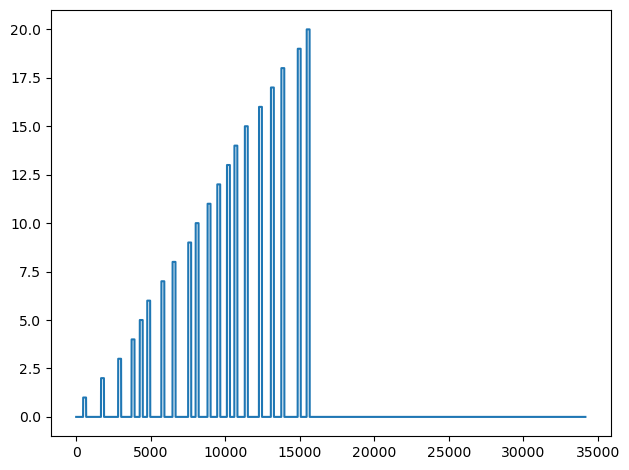

In [109]:
plt.plot(all_data_sets[2]['trial'])

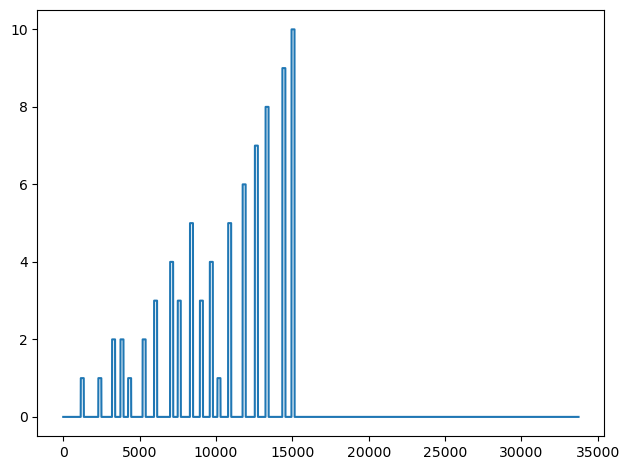

In [94]:
plt.plot(all_data_sets[0]['trial'])

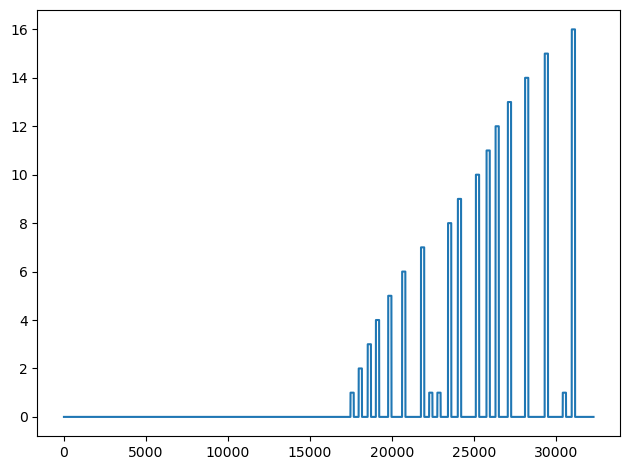

In [93]:
plt.plot(all_data_sets[1]['trial'])


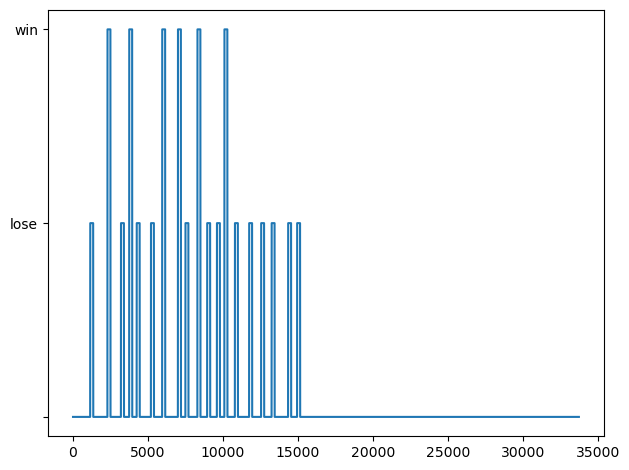

In [98]:
plt.plot(all_data_sets[0]['stimulus'])


In [84]:
len(np.arange(-10,10,rec.timebin/1000))

200

/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  func(*args, **kwargs)
/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


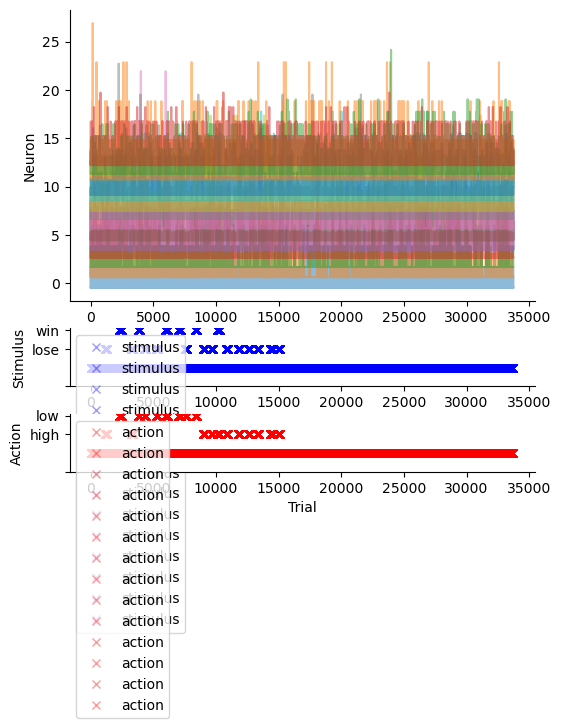

In [110]:
f, axs = plt.subplots(3, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [5, 1, 1]})
    
import seaborn as sns
stimulus = all_data_sets[0]['stimulus']
action = all_data_sets[0]['action']
raster = all_data_sets[0]['raster']
n_visualize = raster.shape[1]

for n in range(n_visualize):
    z_scored_x = (raster[:, n] - np.nanmean(raster[:, n])) / np.nanstd(raster[:, n])
    axs[0].plot(z_scored_x + n, alpha=0.5)
    axs[0].set_ylabel('Neuron')

    axs[1].plot(stimulus, label='stimulus', linewidth=4, alpha=0.4, linestyle='', marker='x', color='b')
    axs[1].legend()
    axs[1].set_ylabel('Stimulus')
    axs[1].set_yticks([-1, 1, 2])

    axs[2].plot(action, label='action', linewidth=4, alpha=0.4, linestyle='', marker='x', color='r')
    axs[2].legend()
    axs[2].set_xlabel('Trial')
    axs[2].set_ylabel('Action')
    axs[2].set_yticks([-1, 1, 2])


sns.despine(f)

In [111]:
from decodanda import Decodanda, generate_synthetic_data, plot_perfs_null_model
# Generating 4 data sets with low number of neurons (random between 5 and 10)

# Let's see how well they perform when decoded individually

# results = {}
# null_models = {}
# for i, dataset in enumerate(all_data_sets):
#     print('Decoding dataset #%u' % i)
#     res, null = Decodanda(data=dataset, conditions={'stimulus': ['win', 'lose'], 'action': ['high', 'low']}).decode(training_fraction=0.75)
#     results[i] = res['stimulus']
#     null_models[i] = null['stimulus']

# plot_perfs_null_model(results, null_models)
# plt.xlabel('Dataset #')
# plt.ylim([0.38, 1])

In [112]:
PSdec = Decodanda(data=all_data_sets, conditions={'stimulus': ['win', 'lose'], 'action': ['high', 'low']}, min_trials_per_condition=2, verbose = True)


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = win, action = high):	Selected 200 time bin out of 33739, divided into 1 trials - 14 neurons
			(stimulus = win, action = low):	Selected 1000 time bin out of 33739, divided into 5 trials - 14 neurons
			(stimulus = lose, action = high):	Selected 2000 time bin out of 33739, divided into 10 trials - 14 neurons
			(stimulus = lose, action = low):	Selected 600 time bin out of 33739, divided into 3 trials - 14 neurons
			===> Session discarded for insufficient data.

		[Decodanda]	building conditioned rasters for session 1
			(stimulus = win, action = high):	Selected 3200 time bin out of 32309, divided into 16 trials - 6 neurons
			(stimulus = win, action = low):	Selected 200 time bin out of 32309, divided into 1 trials - 6 neurons
			(stimulus = lose, action = high):	Selected 200 time bin out of 32309, divided into 1 trials - 6 neurons
			(stimulus = lose, action = low):	Selected 200 time bin out of 32309, divided into 


Testing decoding performance for semantic dichotomy:  stimulus
[['10', '11'], ['00', '01']] 6000

[decode_dichotomy]	Decoding - 6000 time bins - 90 neurons - 8 brains
		(lose high) (lose low)
			vs.
		(win high) (win low)


  0%|          | 0/10 [00:00<?, ?it/s]


Looping over decoding cross validation folds:


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]



[decode_with_nullmodel]	 data <p> = 0.79

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]



Testing decoding performance for semantic dichotomy:  action
[['01', '11'], ['00', '10']] 6000

[decode_dichotomy]	Decoding - 6000 time bins - 90 neurons - 8 brains
		(win low) (lose low)
			vs.
		(win high) (lose high)


  0%|          | 0/10 [00:00<?, ?it/s]


Looping over decoding cross validation folds:


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]



[decode_with_nullmodel]	 data <p> = 0.51

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 10/10 [00:58<00:00,  5.85s/it]



Testing CCGP for semantic dichotomy:  stimulus

[decode_dichotomy]	Cross-condition decoding - 6000 time bins - 90 neurons - 8 brains
		(lose high) (lose low)
			vs.
		(win high) (win low)


100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


		[CCGP_with_nullmodel]		----- Data: <p> = 0.75 -----



100%|██████████| 20/20 [00:12<00:00,  1.63it/s]



Testing CCGP for semantic dichotomy:  action

[decode_dichotomy]	Cross-condition decoding - 6000 time bins - 90 neurons - 8 brains
		(win low) (lose low)
			vs.
		(win high) (lose high)


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


		[CCGP_with_nullmodel]		----- Data: <p> = 0.49 -----



100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


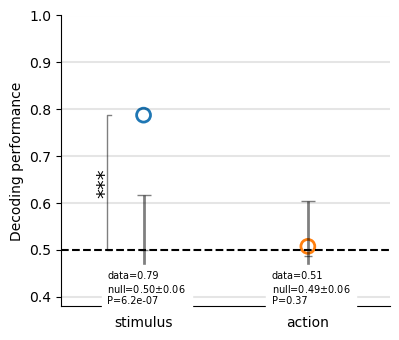

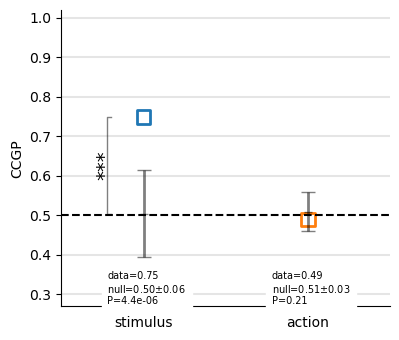

In [113]:
#                       ^list of dictionary

linear = PSdec.decode(training_fraction=0.75, plot = True)

plt.ylim([0.38, 1])

ccgp = PSdec.CCGP(nshuffles=20, plot=True)
#res, null = PSdec.CVI(training_fraction=0.75, nshuffles=20)
#_ = plot_perfs_null_model(res, null, ylabel='CVI', marker='$x$', color='g')

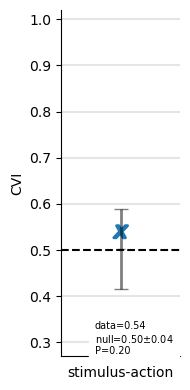

In [114]:
res, null = PSdec.CVI(training_fraction=0.75, nshuffles=20)
_ = plot_perfs_null_model(res, null, ylabel='CVI', marker='$x$', color='g')

In [ ]:
#        Data structure
#         --------------
#         Decodanda works with datasets organized into Python dictionaries.
#         For ``N`` recorded neurons and ``T`` trials (or time bins), the data dictionary must contain:

#         1. a ``TxN`` array, under the ``raster`` key
#             This is the set of features we use to decode. Can be continuous (e.g., calcium fluorescence) or discrete (e.g., spikes) values.

#         2. a ``Tx1`` array specifying a ``trial`` number
#             This array will define the subdivisions for cross validation: trials (or time bins) that share the
#             same ```trial``` value will always go together in either training or testing samples.

#         3. a ``Tx1`` array for each variable we want to decode
#             Each value will be used as a label for the ``raster`` feature. Make sure these arrays are
#             synchronized with the ``raster`` array.


#         Say we have a data set with N=50 neurons, T=800 time bins divided into 80 trials, where two experimental
#         variables are specified ``stimulus`` and ``action``.
#         A properly-formatted data set would look like this:

#         >>> data = {
#         >>>     'raster': [[0, 1, ..., 0], ..., [0, 2, ..., 1]],     # <800x50 array>, neural activations
#         >>>     'stimulus': ['A', 'A', 'B', ..., 'B'],               # <800x1 array>, values of the stimulus variable
#         >>>     'action': ['left', 'left', 'none', ..., 'left'],    # <800x1 array>, values of the action variable
#         >>>     'trial':  [1, 1, 1, ..., 2, 2, 2, ..., 80, 80, 80],  # <800x1 array>, trial number, 80 unique numbers
#         >>> }

#         The ``conditions`` dictionary is used to specify which variables - out of
#         all the keywords in the ``data`` dictionary, and which and values - out of
#         all possible values of each specified variable - we want to decode.

#         It has to be in the form ``{key: [value1, value2]}``:

#         >>> conditions = {
#         >>>     'stimulus': ['A', 'B'],
#         >>>     'action': ['left', 'right']
#         >>> }

#         If more than one variable is specified, `Decodanda` will balance all
#         conditions during each decoding analysis to disentangle
#         the variables and avoid confounding correlations.